In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import control as ctl

from utils import BandFilter, Integral, LowBandFilter, NumpyFilter

# IMPORTANDO DADOS

In [56]:
df = pd.read_csv('DataBase.csv')
df

,ax,ay,az,gx,gy,gz,time
0,-0.083984,-0.072266,-1.013184,-7.080078,-2.258301,-2.624512,0.002044
1,-0.079590,-0.069824,-1.009766,-7.934570,-2.990723,-2.624512,0.005294
2,-0.069336,-0.077148,-1.021484,-9.277344,-4.943848,-0.793457,0.018674
3,-0.072266,-0.074219,-1.034180,-9.582520,-4.821777,-0.244141,0.021819
4,-0.088379,-0.082520,-1.055664,-10.253910,-3.967285,-0.061035,0.035171
...,...,...,...,...,...,...,...
893,-0.046387,-0.035645,-1.042969,-3.723145,-1.159668,2.990723,8.259801
894,-0.051758,-0.042969,-1.040039,-2.746582,-0.061035,4.028320,8.273132
895,-0.057617,-0.035156,-1.039551,-2.380371,-0.305176,4.211426,8.276249
896,-0.060547,-0.018555,-1.047852,-2.197266,-0.244141,4.394531,8.289582


# NORMALIZANDO DADOS

In [57]:
dt = float(np.round(df.time.diff().mean(), 3))
dt

0.009

In [58]:
def normalizeTable(df, key, dt=0.15):
    df[key]  = df[key] - df[key][0] # INICIA NO TEMPO 0
    initTime = df[key].iloc[0]
    finalTime = df[key].iloc[-1] + dt
    newAxis = np.arange(initTime, finalTime, dt)
    df = df.set_index(key).reindex(newAxis, method='ffill')
    return df.reset_index().rename(columns={'index': key})


df = normalizeTable(df, 'time', dt)
df.head()

,time,ax,ay,az,gx,gy,gz
0,0.000,-0.083984,-0.072266,-1.013184,-7.080078,-2.258301,-2.624512
1,0.009,-0.079590,-0.069824,-1.009766,-7.934570,-2.990723,-2.624512
2,0.018,-0.069336,-0.077148,-1.021484,-9.277344,-4.943848,-0.793457
3,0.027,-0.072266,-0.074219,-1.034180,-9.582520,-4.821777,-0.244141
4,0.036,-0.088379,-0.082520,-1.055664,-10.253910,-3.967285,-0.061035


# CONVERSÃO DE UNIDADES
Os sensores entregam dados em unidades digitais (LSB), que precisam ser convertidas para m/s² (aceleração) e rad/s (velocidade angular) para fazer cálculos físicos corretos, como integração e rotação.

In [59]:
# Acelerômetro: ±2g → 16384 LSB/g, g = 9.81 m/s²
df['ax'] = (df['ax'] / 16384.0) * 9.81
df['ay'] = (df['ay'] / 16384.0) * 9.81
df['az'] = (df['az'] / 16384.0) * 9.81

# Giroscópio: ±250°/s → 131 LSB/(°/s), converter para rad/s
df['gx'] = (df['gx'] / 131.0) * (np.pi / 180)
df['gy'] = (df['gy'] / 131.0) * (np.pi / 180)
df['gz'] = (df['gz'] / 131.0) * (np.pi / 180)
df.head()

,time,ax,ay,az,gx,gy,gz
0,0.000,-0.000050,-0.000043,-0.000607,-0.000943,-0.000301,-0.000350
1,0.009,-0.000048,-0.000042,-0.000605,-0.001057,-0.000398,-0.000350
2,0.018,-0.000042,-0.000046,-0.000612,-0.001236,-0.000659,-0.000106
3,0.027,-0.000043,-0.000044,-0.000619,-0.001277,-0.000642,-0.000033
4,0.036,-0.000053,-0.000049,-0.000632,-0.001366,-0.000529,-0.000008


In [60]:
df_aux   = df.copy()
df['gx'] = df['gy']
df['gy'] = -df_aux['gx']

# VETORIZAÇÃO

In [61]:
aData = np.array([[ax, ay, az] for (ax, ay, az) in zip(df.ax, df.ay, df.az)])
wData = np.array([[ax, ay, az] for (ax, ay, az) in zip(df.gx, df.gy, df.gz)])
tData = df.time.to_numpy()
aData

array([[-5.02858301e-05, -4.32696204e-05, -6.06648867e-04],
       [-4.76549011e-05, -4.18074609e-05, -6.04602323e-04],
       [-4.15152686e-05, -4.61927417e-05, -6.11618533e-04],
       ...,
       [-3.62528119e-05, -1.11098969e-05, -6.27406501e-04],
       [-3.62528119e-05, -1.11098969e-05, -6.27406501e-04],
       [-3.59606195e-05, -2.92372009e-06, -6.21559061e-04]])

# POSIÇÃO
$a = \frac{dv}{dt}$

$v = \int_0^t a(t)\, dt$, mas $v = \frac{dx}{dt}$

$\frac{dx}{dt} = \int_0^t a(t)\, dt$

$x = \int_0^t \int_0^t a(t)\, dt\, dt$

In [62]:
def plotData(time, data):
    keys, values = list(data.keys()), list(data.values())
    plt.figure(figsize=(20, 5))
    plt.subplot(1, 3, 1)
    plt.plot(time, values[0])
    plt.xlabel('time'), plt.ylabel('value')
    plt.title(rf'${keys[0]}$')
    plt.grid()

    plt.subplot(1, 3, 2)
    plt.plot(time, values[1])
    plt.xlabel('time'), plt.ylabel('value')
    plt.title(rf'${keys[1]}$')
    plt.grid()

    plt.subplot(1, 3, 3)
    plt.plot(time, values[2])
    plt.xlabel('time'), plt.ylabel('value')
    plt.title(rf'${keys[2]}$')
    plt.grid()

### Aceleração Linear

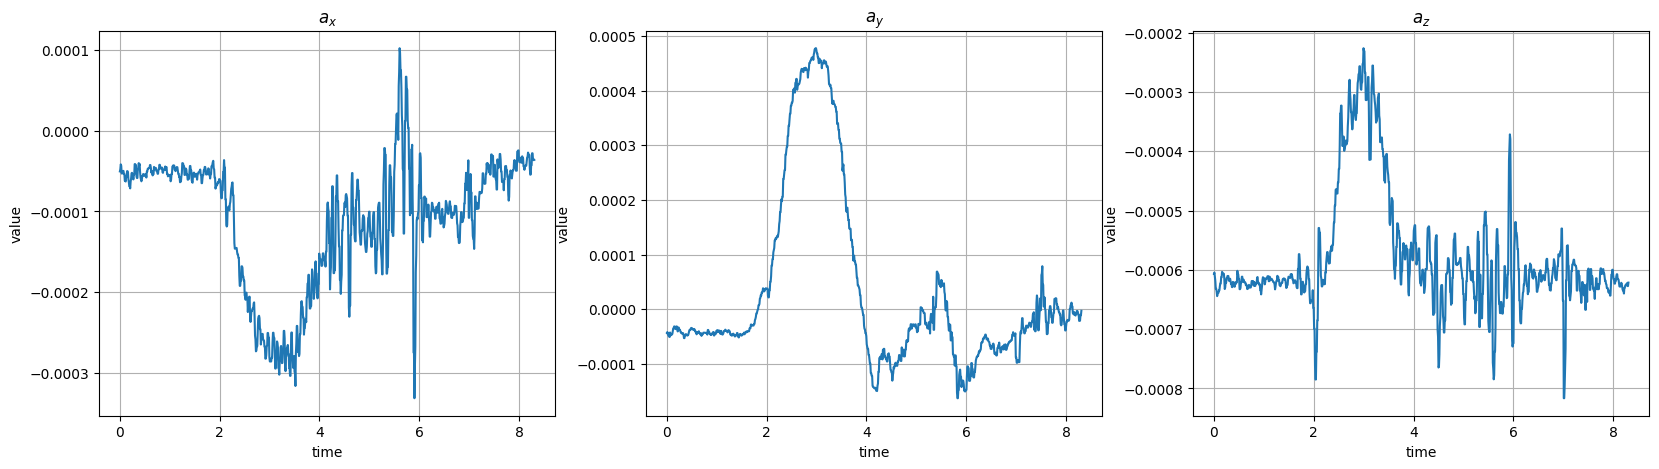

In [63]:
plotData(tData, {
    'a_x': [ax for (ax, ay, az) in aData],
    'a_y': [ay for (ax, ay, az) in aData],
    'a_z': [az for (ax, ay, az) in aData],
})

- Aplicando Filtro Passa Faixa

TransferFunction(array([6.28318531, 0.        ]), array([ 1.        ,  6.28318531, 29.6088132 ]))

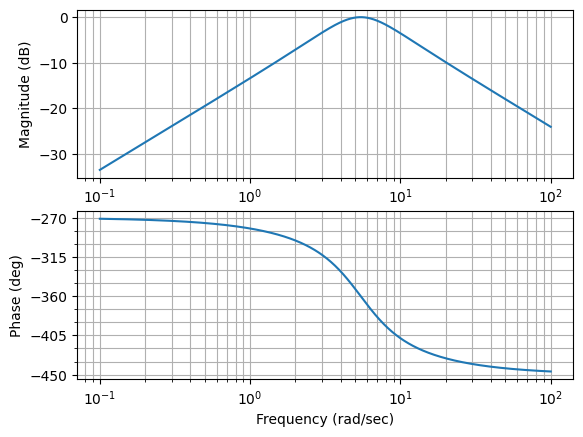

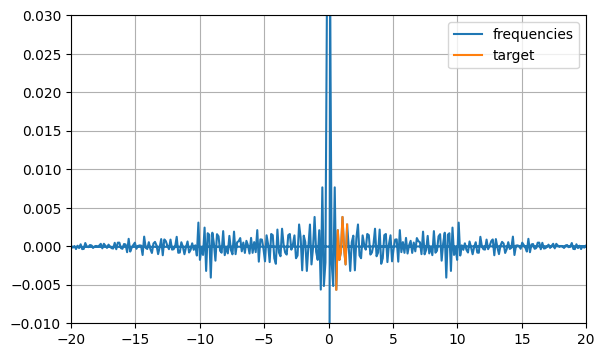

In [ ]:
target = (0.5, 1.5)
filter = BandFilter(dt, target)
filter.plot()
NumpyFilter().see([ax for (ax, ay, az) in aData], dt, target, range=(-20, 20), yLim=(-.01, .03))

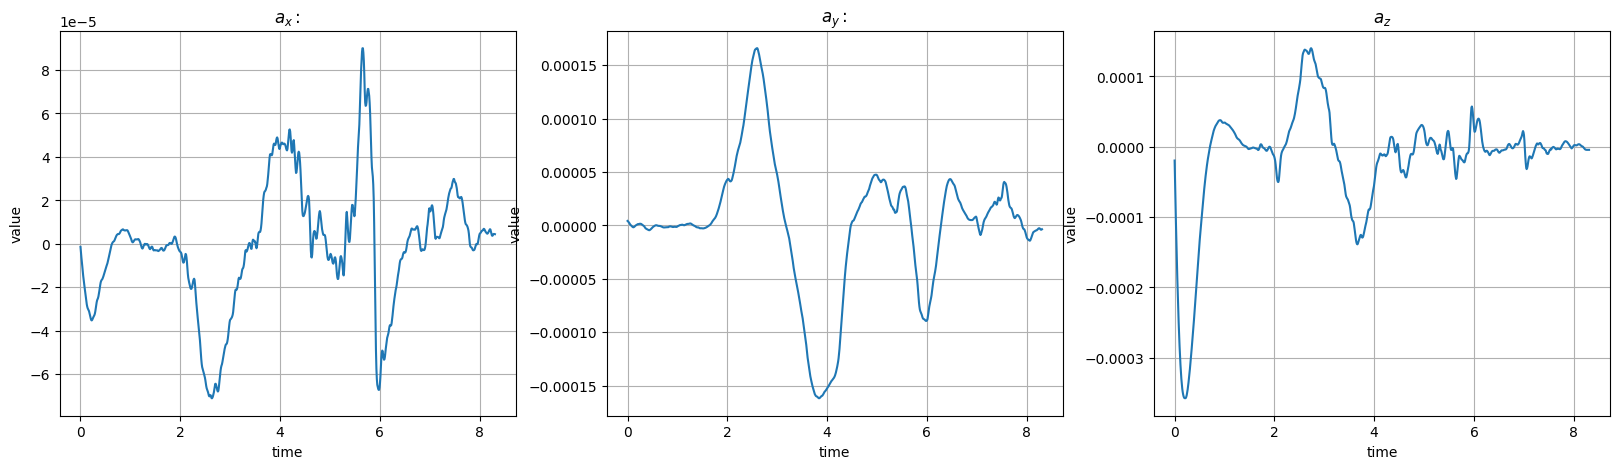

In [65]:
aData = np.column_stack([
    filter.apply([ax for (ax, ay, az) in aData]),
    filter.apply([ay for (ax, ay, az) in aData]),
    filter.apply([az for (ax, ay, az) in aData])
])

plotData(tData, {
    'a_x: ': [ax for (ax, ay, az) in aData],
    'a_y: ': [ay for (ax, ay, az) in aData],
    'a_z'  : [az for (ax, ay, az) in aData],
})

### Velocidade Linear

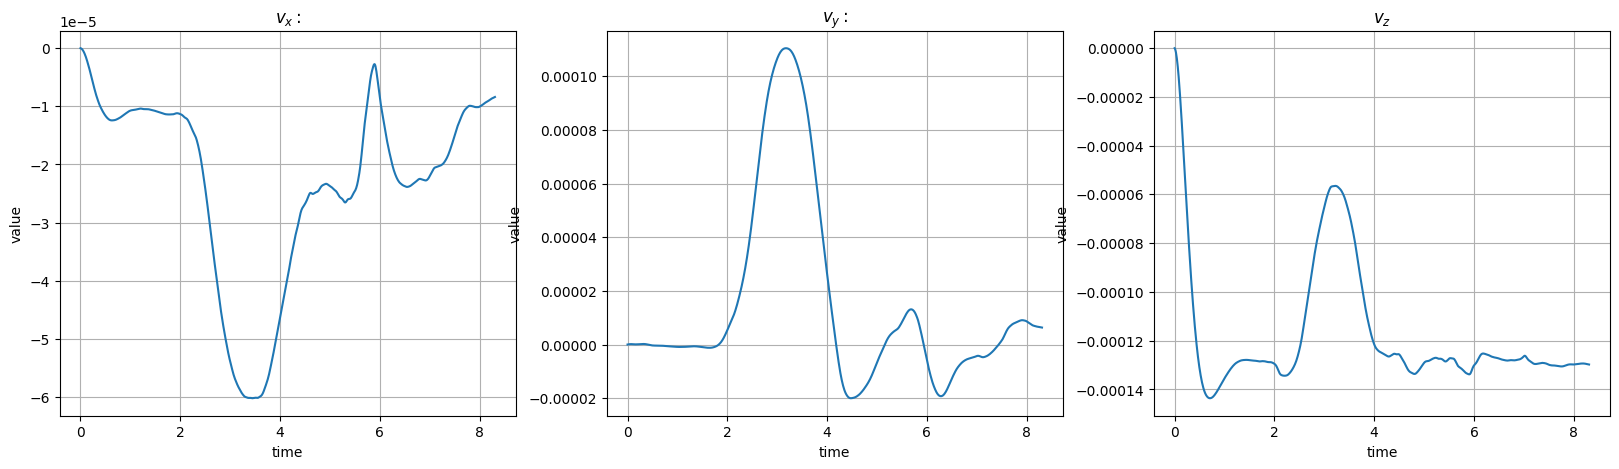

In [66]:
vData = np.column_stack([
    Integral(dt).apply([ax for (ax, ay, az) in aData]),
    Integral(dt).apply([ay for (ax, ay, az) in aData]),
    Integral(dt).apply([az for (ax, ay, az) in aData])
])

plotData(tData, {
    'v_x: ': [vx for (vx, vy, vz) in vData],
    'v_y: ': [vy for (vx, vy, vz) in vData],
    'v_z'  : [vz for (vx, vy, vz) in vData],
})

### Posição Linear

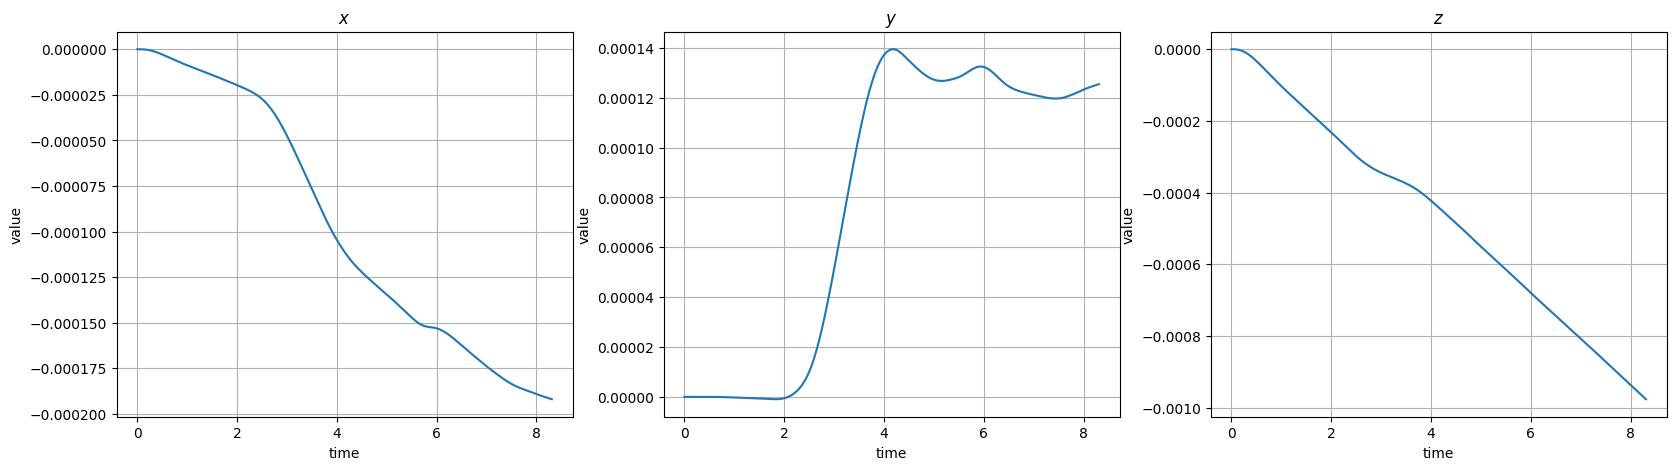

In [67]:
xData = np.column_stack([
    Integral(dt).apply([vx for (vx, vy, vz) in vData]),
    Integral(dt).apply([vy for (vx, vy, vz) in vData]),
    Integral(dt).apply([vz for (vx, vy, vz) in vData])
])

plotData(tData, {
    'x': [x for (x, y, z) in xData],
    'y': [y for (x, y, z) in xData],
    'z': [z for (x, y, z) in xData],
})

TransferFunction(array([157.91367042]), array([  1.        ,  17.77153175, 157.91367042]))

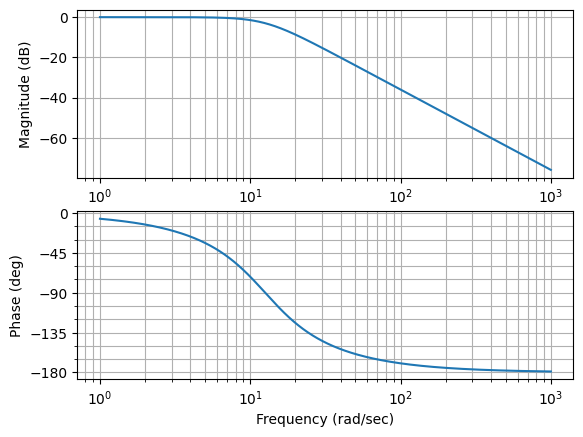

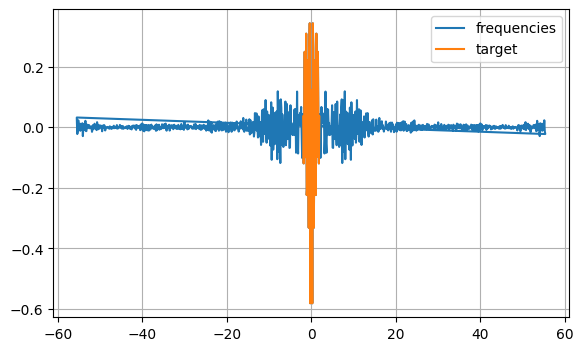

In [68]:
filter = LowBandFilter(f_c=2, dt=dt)
filter.plot()
NumpyFilter().see([wx for (wx, wy, wz) in wData], dt, (-2, 2))

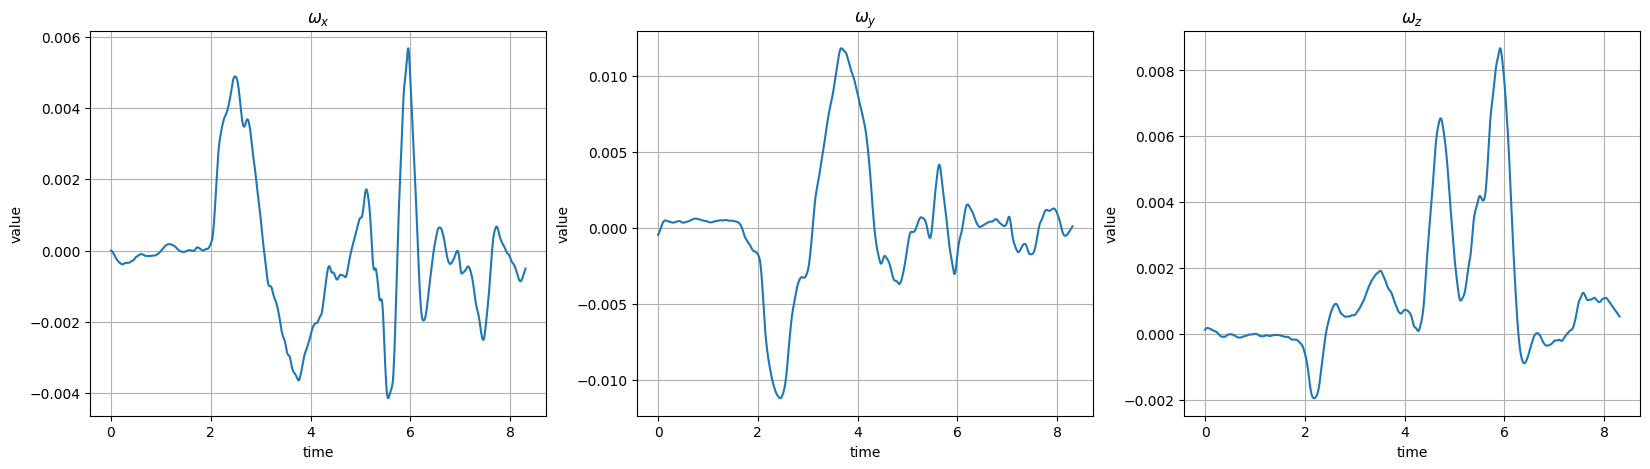

In [69]:
wData = np.column_stack([
    filter.apply([wx for (wx, wy, wz) in wData]),
    filter.apply([wy for (wx, wy, wz) in wData]),
    filter.apply([wz for (wx, wy, wz) in wData])
])

plotData(tData, {
    '\omega_x': [wx for (wx, wy, wz) in wData],
    '\omega_y': [wy for (wx, wy, wz) in wData],
    '\omega_z': [wz for (wx, wy, wz) in wData],
})

### Ângulo

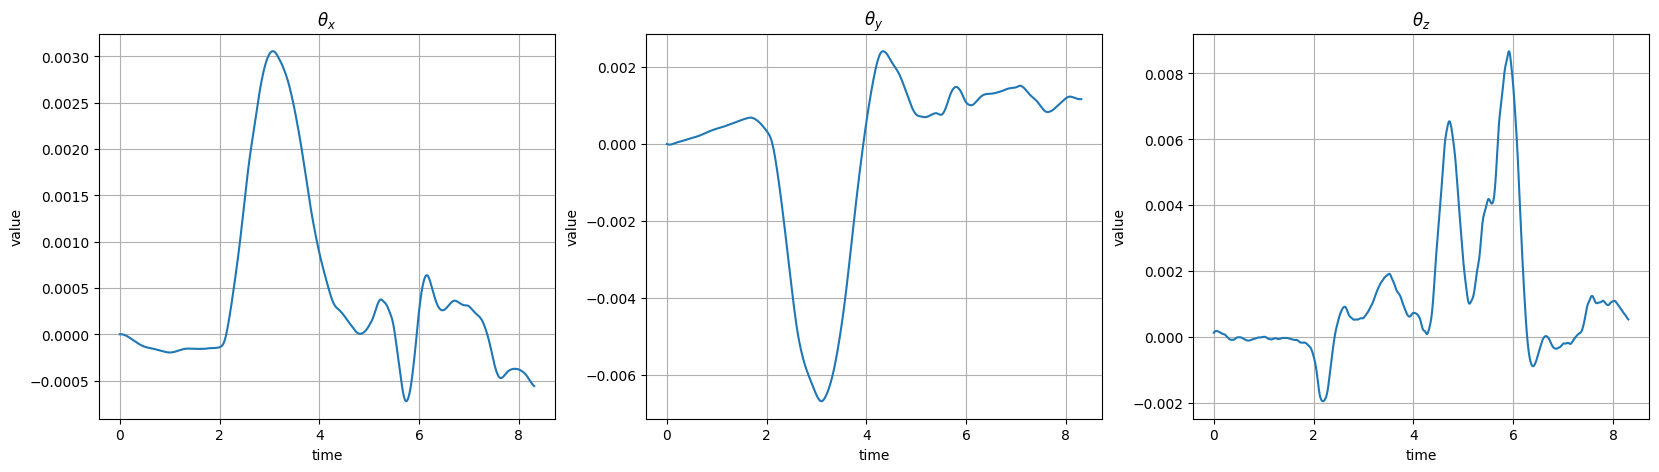

In [70]:
oData = np.column_stack([
    Integral(dt).apply([wx for (wx, wy, wz) in wData]),
    Integral(dt).apply([wy for (wx, wy, wz) in wData]),
    Integral(dt).apply([wz for (wx, wy, wz) in wData])
])

plotData(tData, {
    r'\theta_x': [ox for (ox, oy, oz) in oData],
    r'\theta_y': [oy for (ox, oy, oz) in oData],
    r'\theta_z': [oz for (ox, oy, oz) in wData],
})

### Campo Vetorial

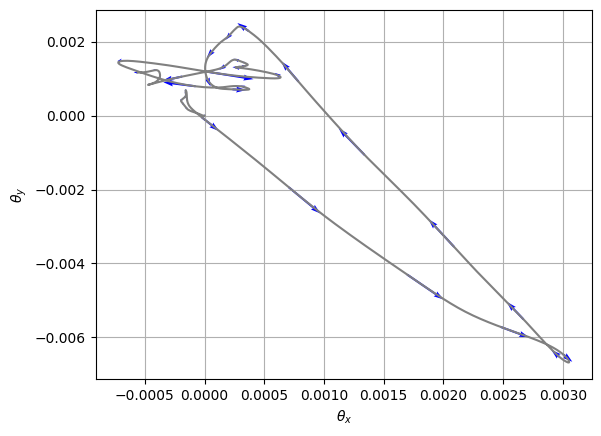

In [71]:
indices = np.linspace(0, len(oData)-1, 40, dtype=int)
x = np.array([ox for (ox, oy, oz) in oData])[indices]
y = np.array([oy for (ox, oy, oz) in oData])[indices]
u = np.array([wx for (wx, wy, wz) in wData])[indices]
v = np.array([wy for (wx, wy, wz) in wData])[indices]

plt.plot([ox for (ox, oy, oz) in oData], [oy for (ox, oy, oz) in oData], color='gray')
plt.quiver(x, y, u, v, angles='xy', scale_units='xy', scale=15, width=0.004, color='blue')
plt.xlabel(r'$\theta_x$'), plt.ylabel(r'$\theta_y$'), plt.grid()
plt.show()

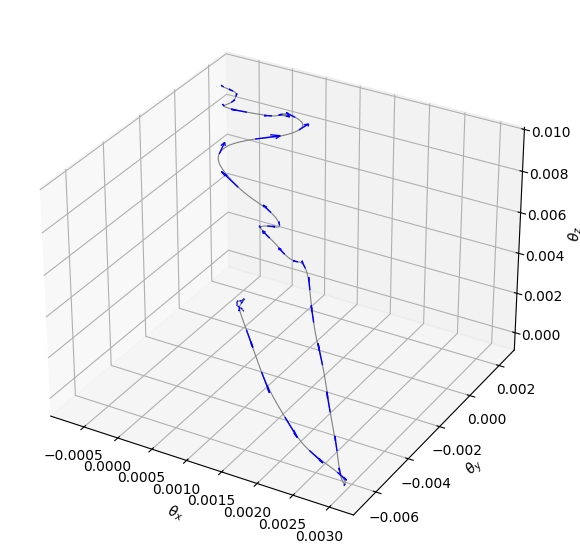

In [72]:
fig = plt.figure(figsize=(7, 7))
ax  = fig.add_subplot(111, projection='3d')
indices = np.linspace(0, len(oData)-1, 50, dtype=int)

x = np.array([ox for (ox, oy, oz) in oData])[indices]
y = np.array([oy for (ox, oy, oz) in oData])[indices]
z = np.array([oz for (ox, oy, oz) in oData])[indices]

u = np.array([wx for (wx, wy, wz) in wData])[indices]
v = np.array([wy for (wx, wy, wz) in wData])[indices]
w = np.array([wz for (wx, wy, wz) in wData])[indices]

plt.plot([ox for (ox, oy, oz) in oData], [oy for (ox, oy, oz) in oData], [oz for (ox, oy, oz) in oData], lw=0.8, color='gray')
ax.quiver(x, y, z, u, v, w, length=0.08, normalize=False, color='blue', linewidth=1)
ax.set_xlabel(r'$\theta_x$'), ax.set_ylabel(r'$\theta_y$'), ax.set_zlabel(r'$\theta_z$')
plt.show()

# INFERENCIA
$\theta = \cos^{-1} \left( \frac{\vec{u} \cdot \vec{v}}{\|\vec{u}\| \cdot \|\vec{v}\|} \right)$

In [73]:
ux = np.array([1, 0, 0])
uy = np.array([0, 1, 0])
uz = np.array([0, 0, 1])

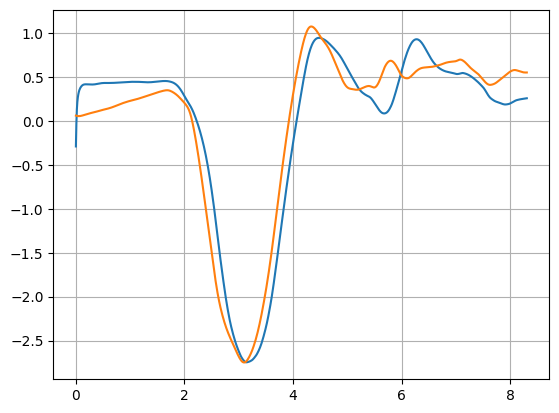

In [74]:
def norm(data):
    mean = np.mean(data)
    std  = np.std(data)
    return [(x - mean)/std for x in data]

def angle(u, v):
    return np.arccos((u @ v)/(np.linalg.norm(u)*np.linalg.norm(v)))

theta_x = [angle(ux, v) for v in vData]
theta_y = [angle(uy, v) for v in vData]
theta_z = [angle(uz, v) for v in vData]

plt.plot(tData, norm(theta_y))
plt.plot(tData, norm([oy for (ox, oy, oz) in oData]))
plt.grid()

# QUARTENION

In [75]:
# Produto de quaternions: q1 ⊗ q2
def quatProduct(q1, q2):
    w1, x1, y1, z1 = q1
    w2, x2, y2, z2 = q2

    w = w1*w2 - x1*x2 - y1*y2 - z1*z2
    x = w1*x2 + x1*w2 + y1*z2 - z1*y2
    y = w1*y2 - x1*z2 + y1*w2 + z1*x2
    z = w1*z2 + x1*y2 - y1*x2 + z1*w2

    return np.array([w, x, y, z])

def normalize(v):
    norm = np.linalg.norm(v)
    return v / norm if norm != 0 else v

- Quartenions a partir da aceleração

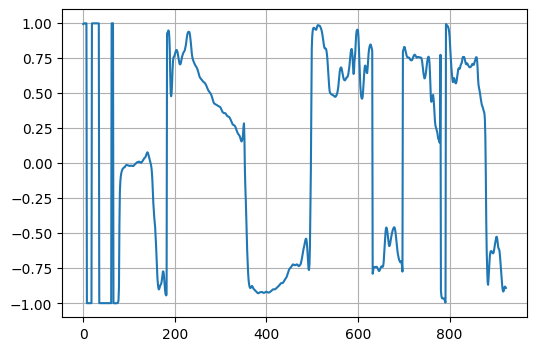

In [76]:
qaData = [np.array([1.0, 0.0, 0.0, 0.0]) for _ in range(len(aData))]

for i, q in enumerate(qaData):
    ax, ay, az = aData[i]
    ax, ay, az = normalize(np.array([ax, ay, az]))

    pitch = np.arctan2(-ax, np.sqrt(ay**2 + az**2))
    roll  = np.arctan2(ay, az)
    yaw   = 0  # sem magnetômetro

    qroll  = np.array([np.cos(roll/2),  np.sin(roll/2), 0, 0])
    qpitch = np.array([np.cos(pitch/2), 0, np.sin(pitch/2), 0])
    qyaw   = np.array([np.cos(yaw/2),   0, 0, np.sin(yaw/2)])

    #q = q_yaw ⊗ (q_pitch ⊗ q_roll)
    q_temp  = quatProduct(qpitch, qroll)
    q_final = quatProduct(qyaw, q_temp)
    qaData[i] = q_final.copy()


plt.figure(figsize=(6, 4))
plt.plot([q1 for (q0, q1, q2, q3) in qaData])
plt.grid()

- Quartenions a partir da velocidade angular

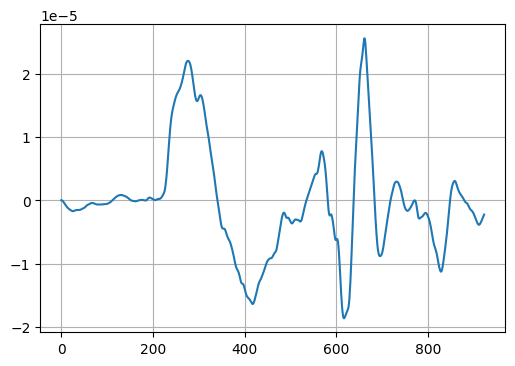

In [77]:
qwData = [np.array([1.0, 0.0, 0.0, 0.0]) for _ in range(len(wData))]

for i, q in enumerate(qwData):
    wx, wy, wz = wData[i]
    omega = np.array([0.0, wx, wy, wz])
    q_dot = 0.5 * quatProduct(q, omega)
    q_new = q + q_dot * dt
    qwData[i] = normalize(q_new).copy()


plt.figure(figsize=(6, 4))
plt.plot([q1 for (q0, q1, q2, q3) in qwData])
plt.grid()

- Comparando os dois com saída normalizada (para ficarem na mesma escala)

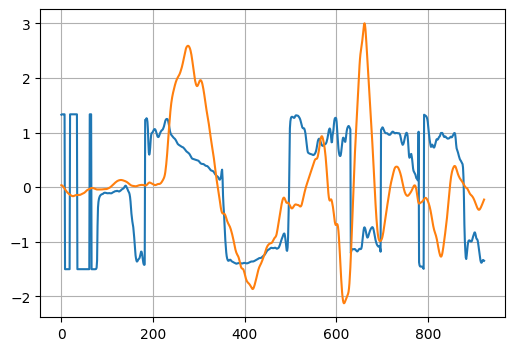

In [78]:
plt.figure(figsize=(6, 4))
plt.plot(norm([q1 for (q0, q1, q2, q3) in qaData]))
plt.plot(norm([q1 for (q0, q1, q2, q3) in qwData]))
plt.grid()

# ROW, PITCH, YAW

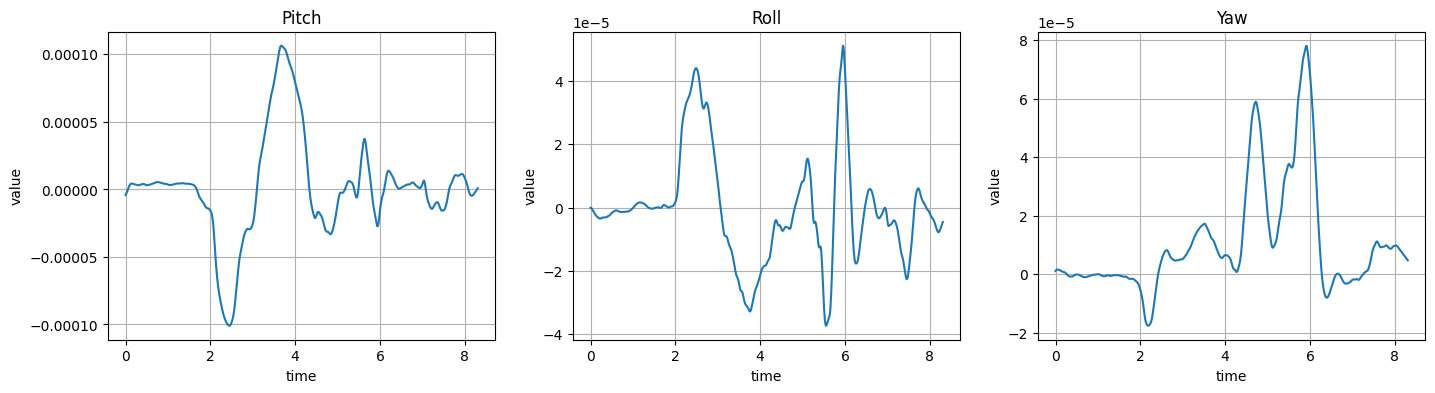

In [79]:
def getEuler(q0, q1, q2, q3):
    # Roll (x-axis rotation)
    sinr_cosp = 2 * (q0 * q1 + q2 * q3)
    cosr_cosp = 1 - 2 * (q1**2 + q2**2)
    roll = np.arctan2(sinr_cosp, cosr_cosp)

    # Pich (y-axis rotation)
    sinp  = 2*(q0 * q2 - q3 * q1)
    pitch = np.sign(sinp)*(np.pi/2) if abs(sinp) >= 1 else np.arcsin(sinp)

    # Yaw (z-axis rotation)
    siny_cosp = 2 * (q0 * q3 + q1 * q2)
    cosy_cosp = 1 - 2 * (q2**2 + q3**2)
    yaw = np.arctan2(siny_cosp, cosy_cosp)
    return pitch, roll, yaw


eulerData = np.array([getEuler(q0, q1, q2, q3) for q0, q1, q2, q3 in qwData])
plt.figure(figsize=(17, 4))
plt.subplot(1, 3, 1)
plt.plot(tData, [pitch for (pitch, roll, yaw) in eulerData])
plt.xlabel('time'), plt.ylabel('value')
plt.title('Pitch')
plt.grid()

plt.subplot(1, 3, 2)
plt.plot(tData, [roll for (pitch, roll, yaw) in eulerData])
plt.xlabel('time'), plt.ylabel('value')
plt.title('Roll')
plt.grid()

plt.subplot(1, 3, 3)
plt.plot(tData, [yaw for (pitch, roll, yaw) in eulerData])
plt.xlabel('time'), plt.ylabel('value')
plt.title('Yaw')
plt.grid()